In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb

In [5]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
def load_artifact(targ_file: str, dir="../tmpw7w4cmxn/storage/"):
    """Load pickled artifacts from Dagster storage"""
    targ_path = os.path.join(dir, targ_file)
    with open(targ_path, 'rb') as fp:
        artifact = pickle.load(fp)
    return artifact

# Load all datasets
print("Loading datasets...")
core_data = load_artifact("core_data")
usage_info = load_artifact("usage_info")
customer_interactions = load_artifact("customer_interactions")

print(f"✓ core_data: {core_data.shape}")
print(f"✓ usage_info: {usage_info.shape}")
print(f"✓ customer_interactions: {customer_interactions.shape}")


Loading datasets...
✓ core_data: (100000, 11)
✓ usage_info: (400000, 4)
✓ customer_interactions: (63019, 4)


In [7]:
print("\n" + "="*60)
print("CORE DATA OVERVIEW")
print("="*60)
print(core_data.head())
print("\nData types:")
print(core_data.dtypes)
print("\nMissing values:")
print(core_data.isnull().sum())

print("\n" + "="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)
target_dist = core_data['has_done_upselling'].value_counts(normalize=True)
print(f"No upsell (0): {target_dist.get(0, 0):.2%}")
print(f"Upsell (1): {target_dist.get(1, 0):.2%}")
print(f"\nThis is an imbalanced dataset - we need to handle this in modeling!")



CORE DATA OVERVIEW
   rating_account_id customer_id  age  contract_lifetime_days  \
0             182161    3.841862   37                     941   
1             874537    5.452041   31                     469   
2             433931    3.129000   42                     274   
3             283294    3.842640   44                     373   
4             881198    1.203226   45                     189   

   remaining_binding_days  has_special_offer  is_magenta1_customer  \
0                     418                  1                     1   
1                     158                  0                     0   
2                     -41                  0                     1   
3                     157                  0                     1   
4                     -82                  1                     0   

  available_gb  gross_mrc smartphone_brand  has_done_upselling  
0           10      66.02           iPhone                   0  
1           30      34.18           iP

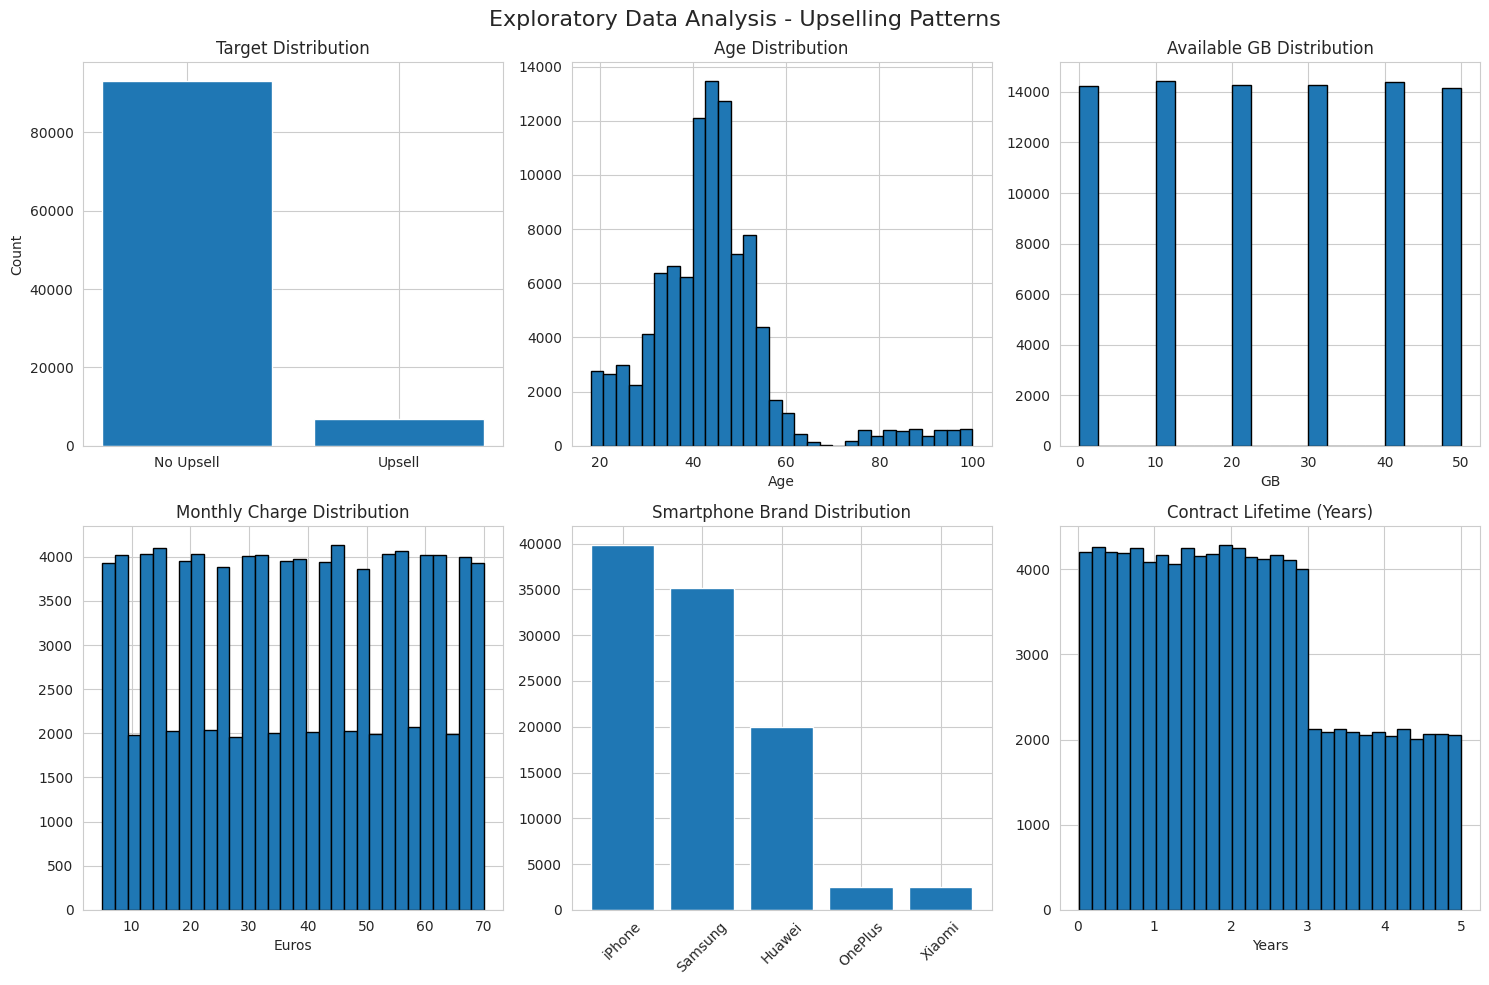

/tmp/ipykernel_7536/1331767255.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_upsell = core_data.groupby('age_group')['has_done_upselling'].mean()


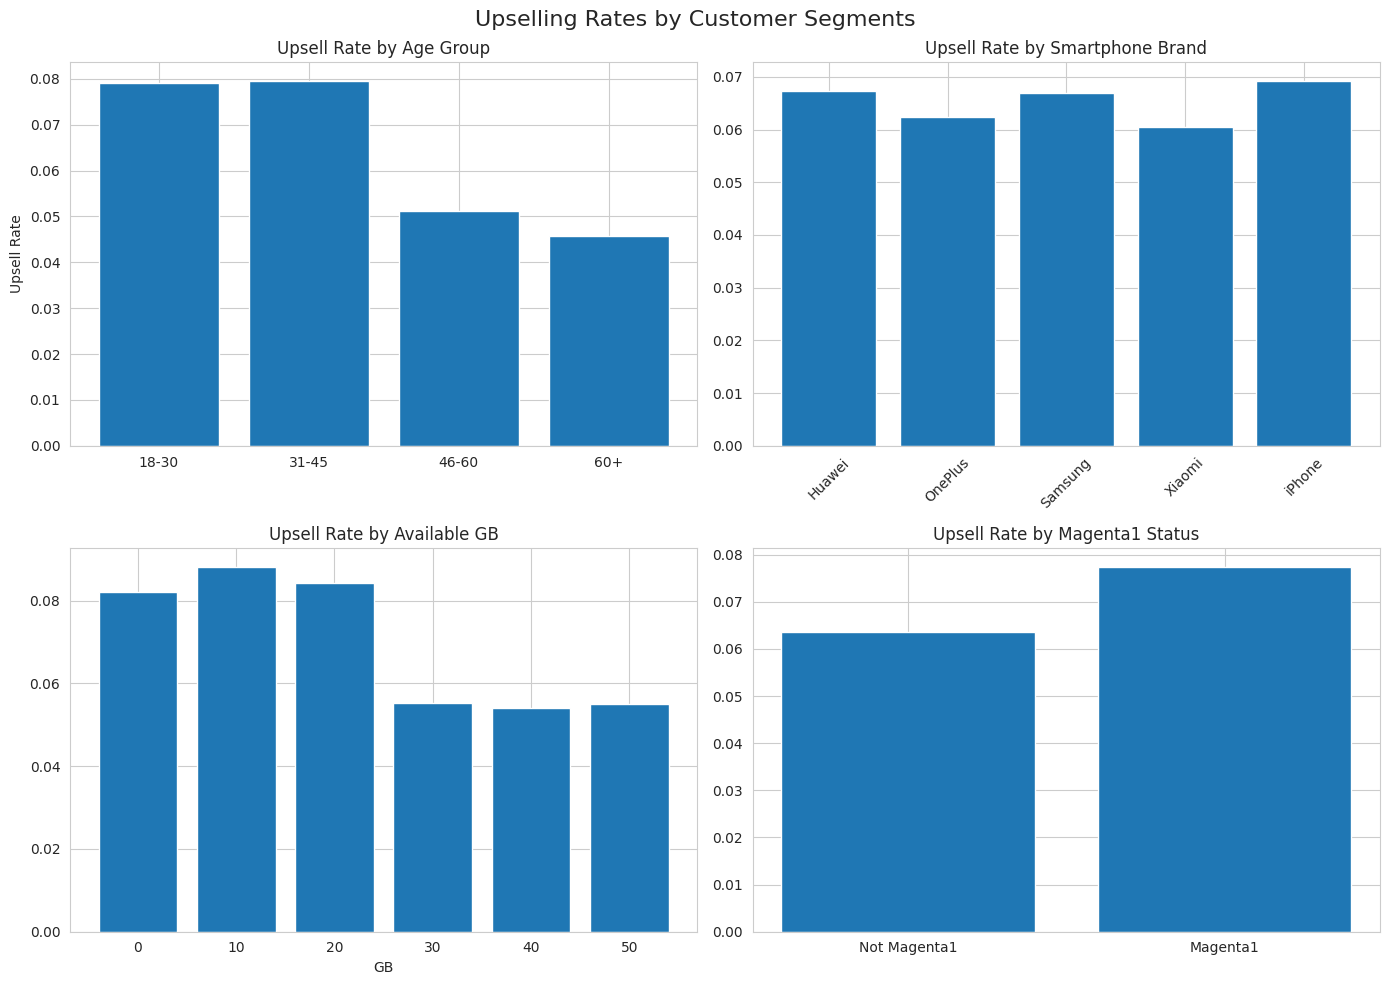

In [8]:
# 1. Target distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis - Upselling Patterns', fontsize=16)

# Target distribution
axes[0, 0].bar(['No Upsell', 'Upsell'], core_data['has_done_upselling'].value_counts())
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_ylabel('Count')

# Age distribution
axes[0, 1].hist(core_data['age'], bins=30, edgecolor='black')
axes[0, 1].set_title('Age Distribution')
axes[0, 1].set_xlabel('Age')

# Available GB distribution
axes[0, 2].hist(core_data['available_gb'].dropna(), bins=20, edgecolor='black')
axes[0, 2].set_title('Available GB Distribution')
axes[0, 2].set_xlabel('GB')

# Monthly charge distribution
axes[1, 0].hist(core_data['gross_mrc'], bins=30, edgecolor='black')
axes[1, 0].set_title('Monthly Charge Distribution')
axes[1, 0].set_xlabel('Euros')

# Smartphone brand
brand_counts = core_data['smartphone_brand'].value_counts()
axes[1, 1].bar(brand_counts.index, brand_counts.values)
axes[1, 1].set_title('Smartphone Brand Distribution')
axes[1, 1].tick_params(axis='x', rotation=45)

# Contract lifetime
axes[1, 2].hist(core_data['contract_lifetime_days']/365, bins=30, edgecolor='black')
axes[1, 2].set_title('Contract Lifetime (Years)')
axes[1, 2].set_xlabel('Years')

plt.tight_layout()
plt.show()

# 2. Upselling rates by segments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Upselling Rates by Customer Segments', fontsize=16)

# By age group
core_data['age_group'] = pd.cut(core_data['age'], bins=[0, 30, 45, 60, 100], 
                                 labels=['18-30', '31-45', '46-60', '60+'])
age_upsell = core_data.groupby('age_group')['has_done_upselling'].mean()
axes[0, 0].bar(age_upsell.index.astype(str), age_upsell.values)
axes[0, 0].set_title('Upsell Rate by Age Group')
axes[0, 0].set_ylabel('Upsell Rate')

# By smartphone brand
brand_upsell = core_data.groupby('smartphone_brand')['has_done_upselling'].mean()
axes[0, 1].bar(brand_upsell.index, brand_upsell.values)
axes[0, 1].set_title('Upsell Rate by Smartphone Brand')
axes[0, 1].tick_params(axis='x', rotation=45)

# By available GB
gb_upsell = core_data.groupby('available_gb')['has_done_upselling'].mean()
axes[1, 0].bar(gb_upsell.index.astype(str), gb_upsell.values)
axes[1, 0].set_title('Upsell Rate by Available GB')
axes[1, 0].set_xlabel('GB')

# By Magenta1 status
magenta_upsell = core_data.groupby('is_magenta1_customer')['has_done_upselling'].mean()
axes[1, 1].bar(['Not Magenta1', 'Magenta1'], magenta_upsell.values)
axes[1, 1].set_title('Upsell Rate by Magenta1 Status')

plt.tight_layout()
plt.show()

In [9]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 1. Aggregate usage features
print("Aggregating usage features...")
usage_agg = usage_info.groupby('rating_account_id').agg({
    'used_gb': ['mean', 'sum', 'min', 'max', 'std'],
    'has_used_roaming': ['sum', 'mean']
}).reset_index()

usage_agg.columns = [
    'rating_account_id', 'used_gb_avg', 'used_gb_total', 
    'used_gb_min', 'used_gb_max', 'used_gb_std',
    'roaming_months_count', 'roaming_rate'
]

# 2. Aggregate interaction features
print("Aggregating interaction features...")
interaction_agg = customer_interactions.groupby('customer_id').agg({
    'n': ['sum', 'mean'],
    'days_since_last': ['min', 'mean']
}).reset_index()

interaction_agg.columns = [
    'customer_id', 'total_interactions', 'avg_interactions_per_type',
    'days_since_last_contact', 'avg_days_since_contact'
]

# 3. Merge all features
print("Merging datasets...")
df = core_data.copy()
df = df.merge(usage_agg, on='rating_account_id', how='left')
df = df.merge(interaction_agg, on='customer_id', how='left')

# Fill NaN for customers without interactions
interaction_cols = ['total_interactions', 'avg_interactions_per_type', 
                     'days_since_last_contact', 'avg_days_since_contact']
df[interaction_cols] = df[interaction_cols].fillna(0)

# 4. Create derived features
df['usage_to_available_ratio'] = df['used_gb_avg'] / (df['available_gb'].replace(0, np.nan) + 1)
df['usage_to_available_ratio'] = df['usage_to_available_ratio'].fillna(0)
df['is_out_of_binding'] = (df['remaining_binding_days'] < 0).astype(int)
df['binding_ending_soon'] = ((df['remaining_binding_days'] >= 0) & 
                              (df['remaining_binding_days'] < 90)).astype(int)

# One-hot encode brand
brand_dummies = pd.get_dummies(df['smartphone_brand'], prefix='brand', drop_first=True)
df = pd.concat([df, brand_dummies], axis=1)

print(f"Final dataset shape: {df.shape}")

# Define features
exclude_cols = ['rating_account_id', 'customer_id', 'has_done_upselling', 
                'smartphone_brand', 'age_group']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")


FEATURE ENGINEERING
Aggregating usage features...
Aggregating interaction features...
Merging datasets...
Final dataset shape: (100000, 30)
Number of features: 25


/tmp/ipykernel_7536/2404823733.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['usage_to_available_ratio'] = df['used_gb_avg'] / (df['available_gb'].replace(0, np.nan) + 1)


In [10]:
print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

# Prepare data
X = df[feature_cols].fillna(0)
y = df['has_done_upselling']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {len(X_train)} samples ({y_train.mean():.2%} positive)")
print(f"Test set: {len(X_test)} samples ({y_test.mean():.2%} positive)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- LOGISTIC REGRESSION ---
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression Performance:")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# --- XGBOOST ---
print("\nTraining XGBoost...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model.fit(X_train, y_train)

xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Performance:")
print(f"ROC-AUC: {roc_auc_score(y_test, xgb_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

/tmp/ipykernel_7536/33582430.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = df[feature_cols].fillna(0)



MODEL TRAINING
Train set: 80000 samples (6.77% positive)
Test set: 20000 samples (6.77% positive)

Training Logistic Regression...
Logistic Regression Performance:
ROC-AUC: 0.5806

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.55      0.70     18646
           1       0.08      0.57      0.15      1354

    accuracy                           0.55     20000
   macro avg       0.52      0.56      0.42     20000
weighted avg       0.89      0.55      0.66     20000


Training XGBoost...
XGBoost Performance:
ROC-AUC: 0.5915

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     18646
           1       0.09      0.54      0.15      1354

    accuracy                           0.58     20000
   macro avg       0.52      0.56      0.44     20000
weighted avg       0.89      0.58      0.68     20000



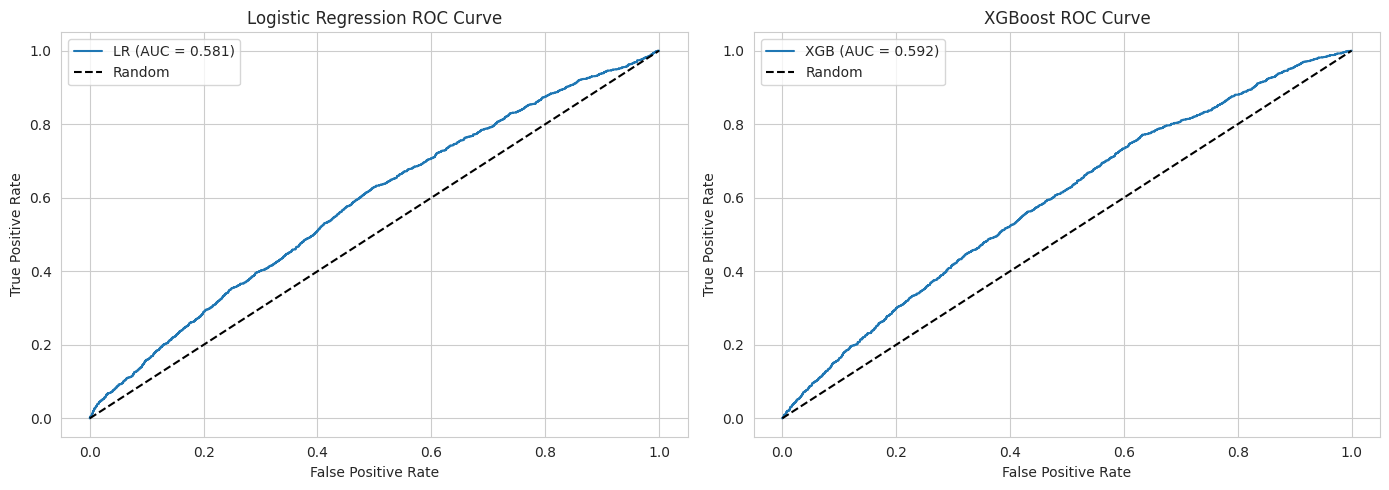

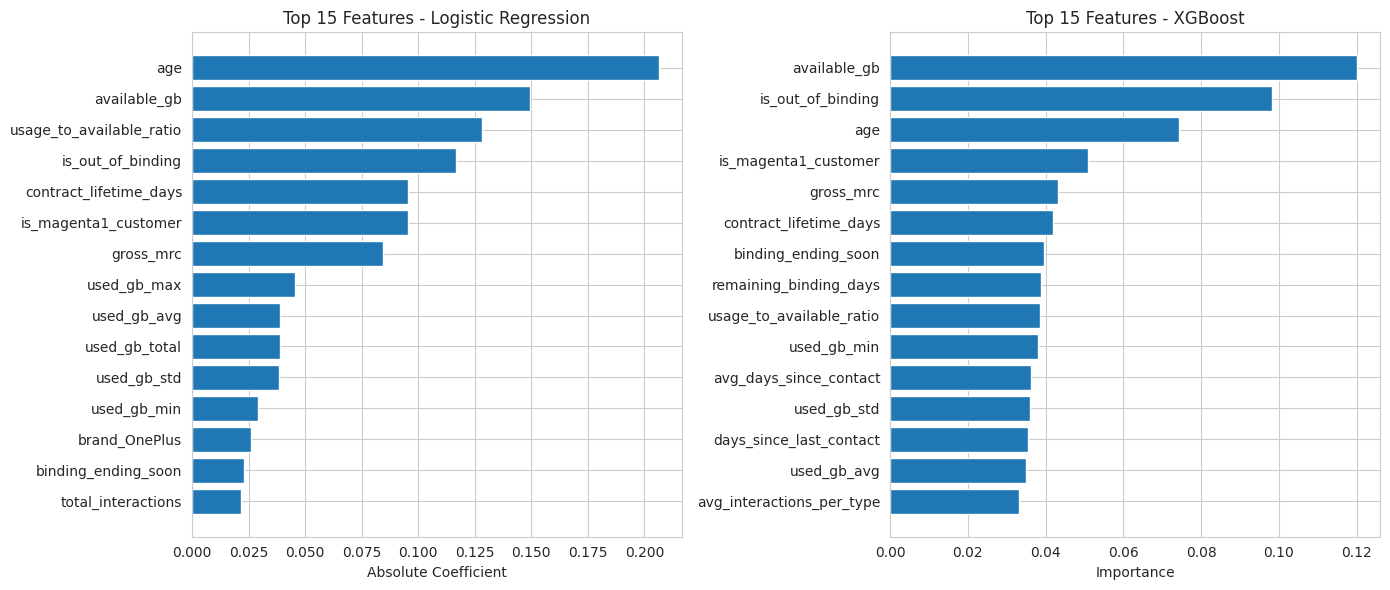


ANALYSIS COMPLETE!

Key Insights:
1. The dataset is highly imbalanced (~7% positive class)
2. Both models handle imbalance using class weights
3. XGBoost typically achieves better performance than Logistic Regression
4. Top features include contract status, usage patterns, and customer interactions

Next Steps:
- Fine-tune model hyperparameters
- Experiment with threshold optimization for business objectives
- Calculate expected business value and ROI


In [ ]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
axes[0].plot(fpr_lr, tpr_lr, label=f'LR (AUC = {roc_auc_score(y_test, lr_pred_proba):.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Logistic Regression ROC Curve')
axes[0].legend()
axes[0].grid(True)

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('XGBoost ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression coefficients
lr_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(lr_model.coef_[0])
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(lr_importance['feature'], lr_importance['importance'])
axes[0].set_xlabel('Absolute Coefficient')
axes[0].set_title('Top 15 Features - Logistic Regression')
axes[0].invert_yaxis()

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(xgb_importance['feature'], xgb_importance['importance'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features - XGBoost')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
